<table class="table table-bordered">
<tr>
<th style="text-align:center; vertical-align: middle; width:50%"><img src='https://www.np.edu.sg/images/default-source/default-album/img-logo.png'"></th>
        <th style="text-align:center;"><h1>Distributed Data Pipelines</h1><h2>Assignment 1 </h2><h3>Diploma in Data Science</h3></th>
    </tr>
</table>

Learning Objectives:
- Design PySpark Based Machine Learning
- Execute PySpark Syntax Correctly
- Evaluate and Select Final Model based on Metrics

You will be **graded on the use of PySpark**, so usage of **Pandas itself should be avoided as much as possible**, especially if a particular native method or function is already available in PySpark. **Penalties will be imposed in such cases.**

In [1]:
import findspark
findspark.init()
import numpy as np

# import the packages
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from datetime import datetime, date
from pyspark.sql import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import * 
from pyspark.ml.feature import OneHotEncoder, StringIndexer, StandardScaler, MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

import handyspark 
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import PowerTransformer

### Step 1: Problem Statement Formulation

In [2]:
# load and explore data
# Create Spark Session
spark = SparkSession.builder.appName("Thailand Property Data Exploration").getOrCreate()
# thailand_df = spark.read.csv('C:\Users\Eng Zhen Ye\DDP\asg 1\thailand_ppty_asg1', header=True, inferSchema=True, mode='binary')

t_df = spark.read.csv('thailand_ppty_asg1.csv', header=True, inferSchema=True).sample(0.4, seed=123) # inferSchema auto detects data type
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [3]:
t_df.printSchema()

root
 |-- sub_property_type: string (nullable = true)
 |-- living_space: double (nullable = true)
 |-- bathroom_number: integer (nullable = true)
 |-- currency: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- property_id: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- floor_level: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- built_year: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- premium: integer (nullable = true)
 |-- bedroom_number: integer (nullable = true)
 |-- address: string (nullable = true)
 |-- listing_label: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- tenure: string (nullable = true)
 |-- price: integer (nullable = true)



In [4]:
t_df.show(5)

+-----------------+------------+---------------+--------+--------------+-----------+---------+-----------+-------+----------+-----------+-------+--------------+--------------------+-------------+-----------+--------+--------+
|sub_property_type|living_space|bathroom_number|currency| property_type|property_id|     city|floor_level|  state|built_year|   latitude|premium|bedroom_number|             address|listing_label|  longitude|  tenure|   price|
+-----------------+------------+---------------+--------+--------------+-----------+---------+-----------+-------+----------+-----------+-------+--------------+--------------------+-------------+-----------+--------+--------+
|         For Sale|       76.86|              2|    Baht|         Condo|    9942777|    Dusit|          6|Bangkok|      2010|13.79101869|      0|             2|Samsen Road, Dusi...|       NORMAL|100.5162452|Freehold| 5500000|
|         For Sale|       180.0|              2|    Baht|Detached House|    9836450|Nong Chok|  

In [5]:
row_count = t_df.count()  # Count the number of rows
col_count = len(t_df.columns)  # Count the number of columns

print(f"Shape of the DataFrame: ({row_count}, {col_count})")

Shape of the DataFrame: (16727, 18)


In [6]:
# value based problem statement
# below in the report

### Step 2: Exploratory Data Analysis and Data Cleansing

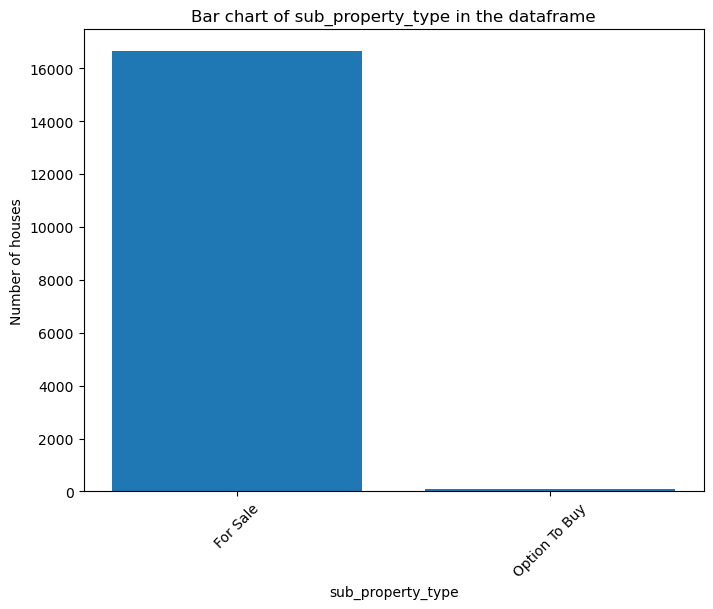

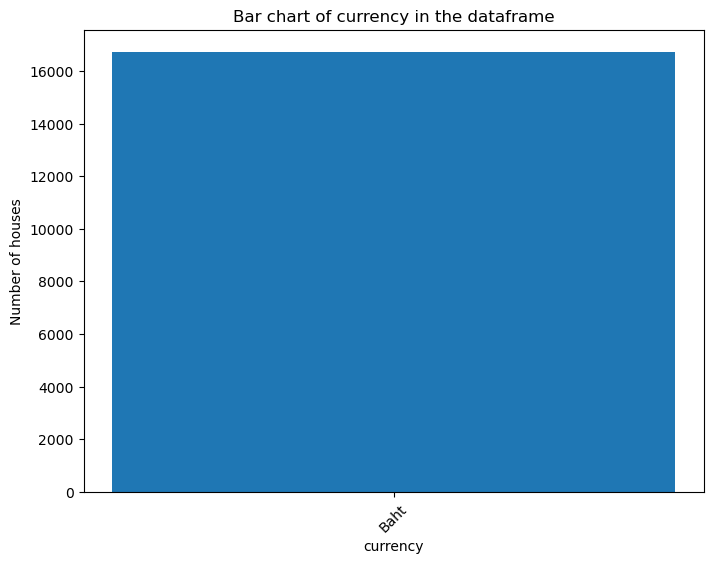

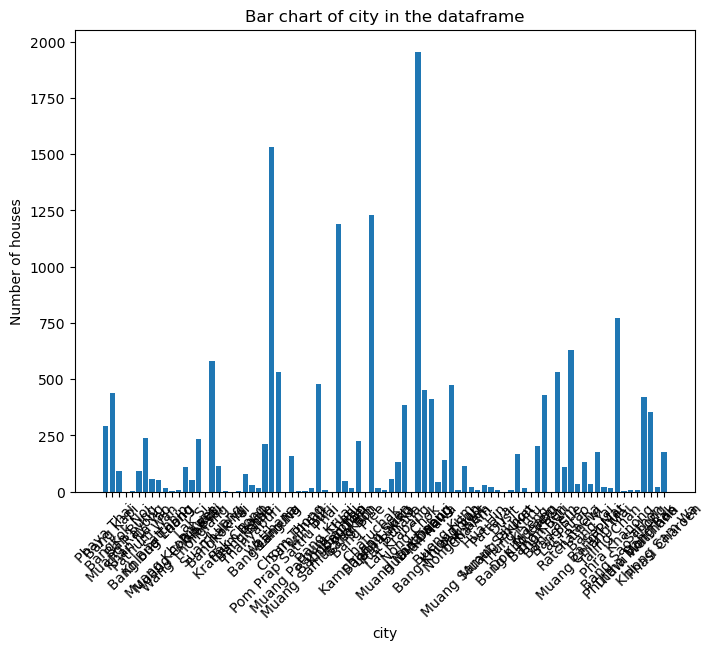

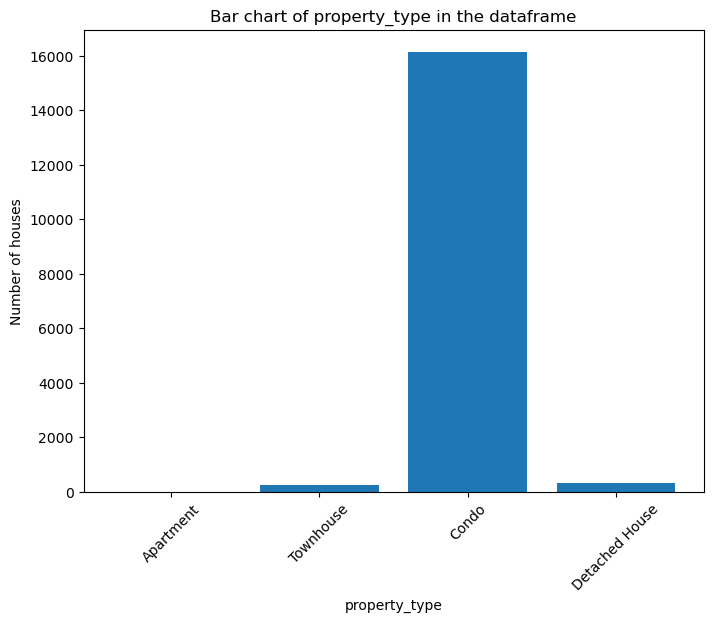

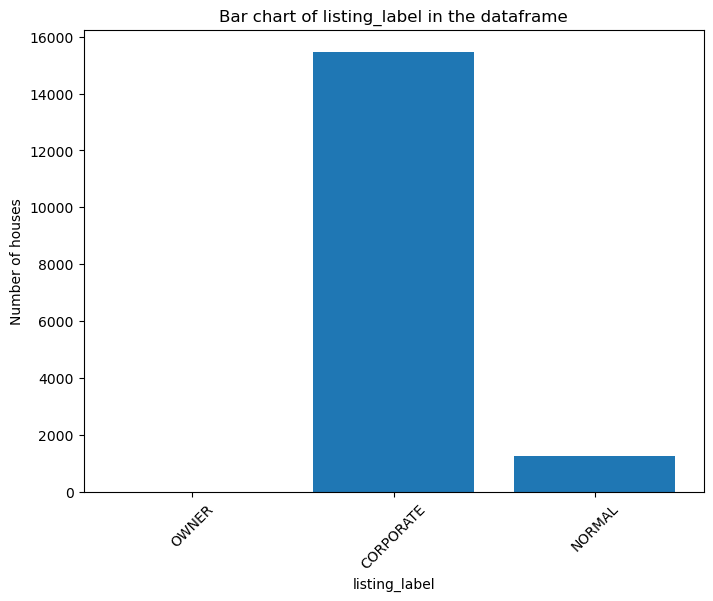

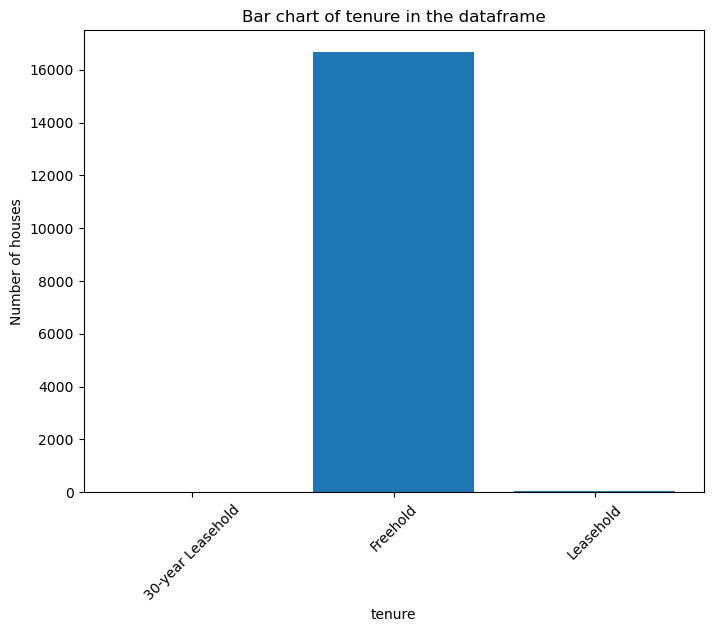

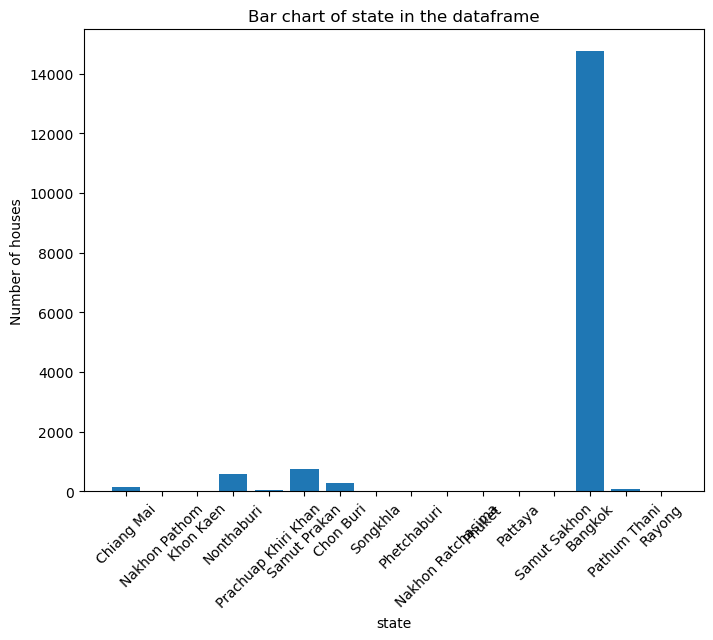

In [7]:
# List of categorical feature column names
categorical_features = ['sub_property_type', 'currency', 'city','property_type', 'listing_label', 'tenure', 'state']  # Replace with your categorical columns

# Create bar chart for each categorical feature
for feature in categorical_features:
    data = t_df.groupBy(feature).count().collect()

    categories = [str(row[feature]) for row in data]
    counts = [row['count'] for row in data]

    plt.figure(figsize=(8, 6))
    plt.bar(categories, counts)
    plt.xlabel(feature)
    plt.ylabel('Number of houses')
    plt.title('Bar chart of ' + feature + ' in the dataframe')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.show()

In [8]:
# counting nulls
t_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in t_df.columns]).show()

+-----------------+------------+---------------+--------+-------------+-----------+----+-----------+-----+----------+--------+-------+--------------+-------+-------------+---------+------+-----+
|sub_property_type|living_space|bathroom_number|currency|property_type|property_id|city|floor_level|state|built_year|latitude|premium|bedroom_number|address|listing_label|longitude|tenure|price|
+-----------------+------------+---------------+--------+-------------+-----------+----+-----------+-----+----------+--------+-------+--------------+-------+-------------+---------+------+-----+
|                0|          19|              0|       0|            0|          0|   0|          0|    0|         0|       0|      0|             0|      0|            0|        0|     0|    0|
+-----------------+------------+---------------+--------+-------------+-----------+----+-----------+-----+----------+--------+-------+--------------+-------+-------------+---------+------+-----+



In [9]:
t_df = t_df.na.drop(how="any")

In [10]:
# dropping of features

# currency only contain "Baht"
t_df = t_df.drop('currency')

# drop sub_property_type, after investigation on imbalance, in the context of properties both categories are synonymous
t_df = t_df.drop('sub_property_type')

# due to imbalance within property_type
# thailand_df = thailand_df.property_type.replace('Apartment', 'Condo')


t_df = t_df.withColumn("property_type", when(col("property_type") == "Apartment", lit("Condo")).otherwise(col("property_type")))


In [11]:
# outlier handling
t_df = t_df.filter((t_df['built_year']>2006))
t_df = t_df.filter((t_df['floor_level']<55))
t_df = t_df.filter((t_df['living_space']<=80)) 
# Calculate the quartiles and IQR
quartiles = t_df.approxQuantile("price", [0.3, 0.65], 0.01) # 0.3, 0.65
q1 = quartiles[0]
q3 = quartiles[1]
iqr = q3 - q1

# Calculate the lower and upper bounds for outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out the outliers from the DataFrame
t_df = t_df.filter((col("price") >= lower_bound) & (col("price") <= upper_bound))# removing clear outliers

# drop far outliers in price (if we were to predict every transaction then this cannot be changed)
# thailand_df = thailand_df.filter((thailand_df['price']<=))      

# thailand_df.show(5)

In [12]:
# data cleansing

In [13]:
# counting nulls
t_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in t_df.columns]).show()

+------------+---------------+-------------+-----------+----+-----------+-----+----------+--------+-------+--------------+-------+-------------+---------+------+-----+
|living_space|bathroom_number|property_type|property_id|city|floor_level|state|built_year|latitude|premium|bedroom_number|address|listing_label|longitude|tenure|price|
+------------+---------------+-------------+-----------+----+-----------+-----+----------+--------+-------+--------------+-------+-------------+---------+------+-----+
|           0|              0|            0|          0|   0|          0|    0|         0|       0|      0|             0|      0|            0|        0|     0|    0|
+------------+---------------+-------------+-----------+----+-----------+-----+----------+--------+-------+--------------+-------+-------------+---------+------+-----+



In [14]:
row_count = t_df.count()  # Count the number of rows
col_count = len(t_df.columns)  # Count the number of columns

print(f"Shape of the DataFrame: ({row_count}, {col_count})")

Shape of the DataFrame: (12367, 16)


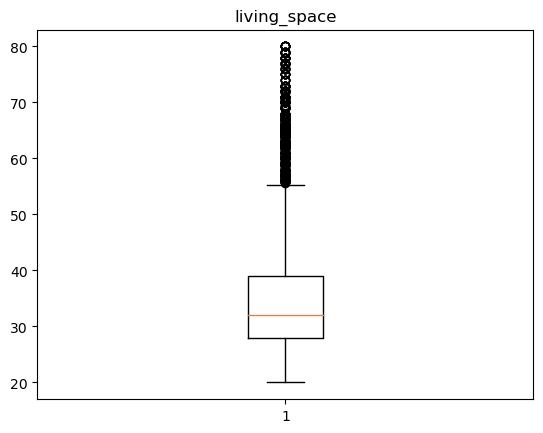

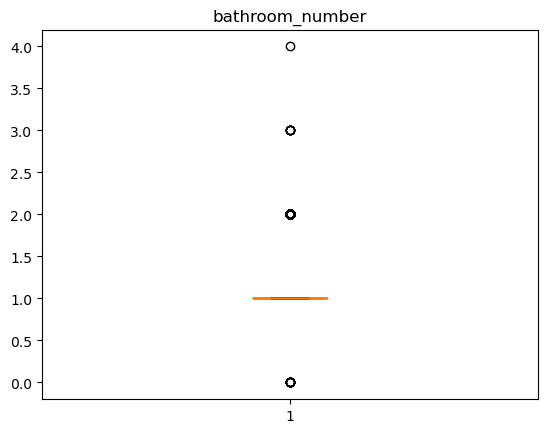

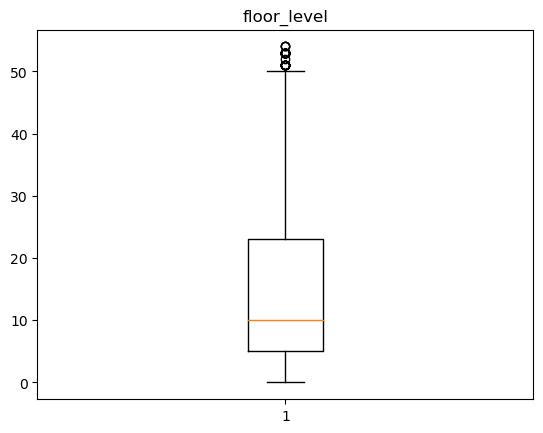

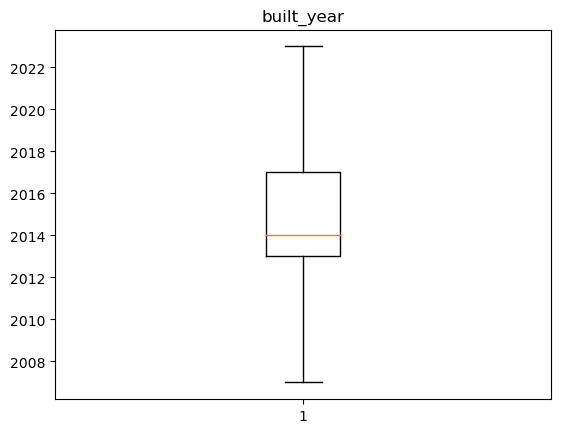

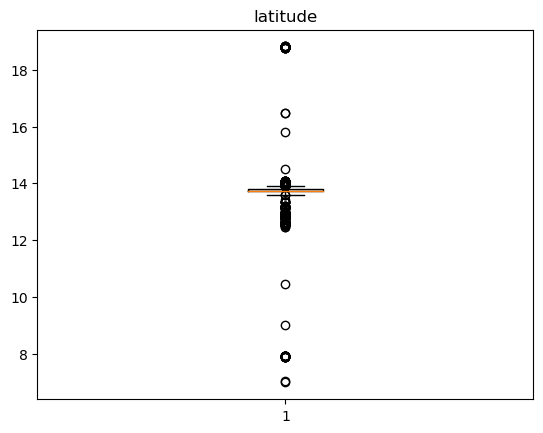

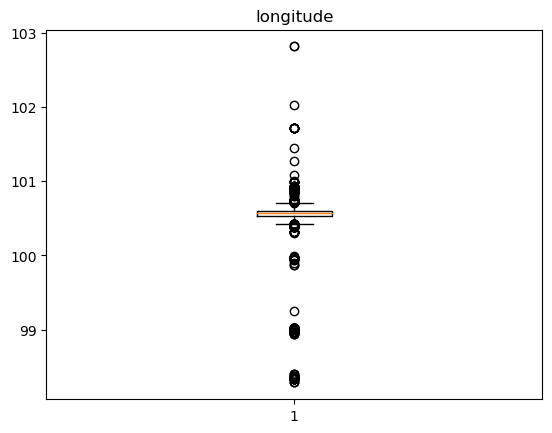

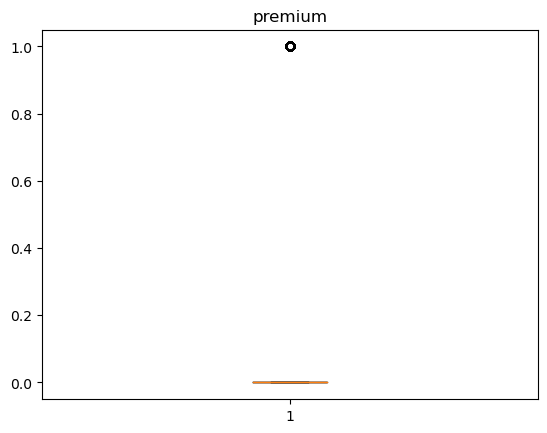

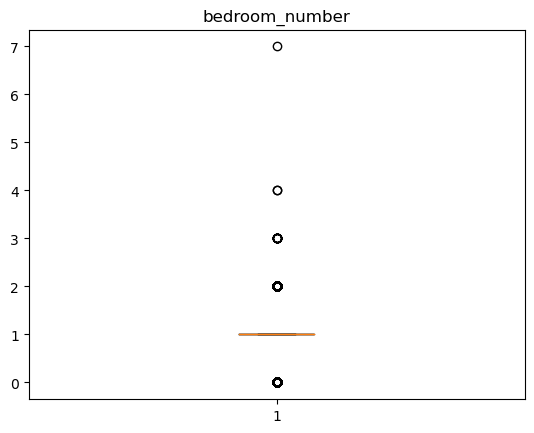

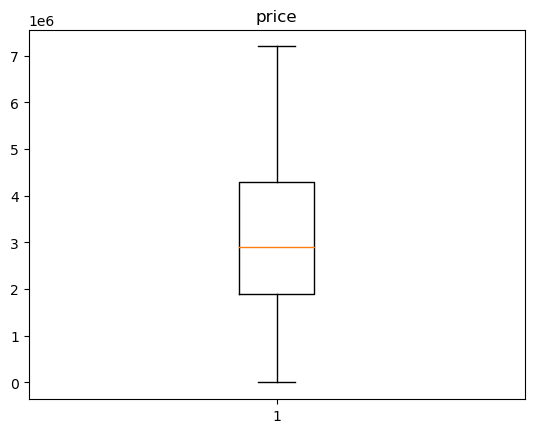

In [15]:
# List of numerical feature column names
numerical_features = ['living_space', 'bathroom_number', 'floor_level', 'built_year', 
                      'latitude', 'longitude', 'premium', 'bedroom_number', 'price']

# Collecting data for each numerical feature
data_to_plot = []
for col in numerical_features:
    data = t_df.select(col).rdd.flatMap(lambda x: x).collect()
    data_to_plot.append(data)

# Creating boxplots for each numerical feature
for i, col in enumerate(numerical_features):
    plt.boxplot(data_to_plot[i])
    plt.title(col)
    plt.show()

In [16]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors

# Selecting the numerical features from the DataFrame
selected_features = ['living_space', 'bathroom_number', 'floor_level', 'built_year', 
                     'latitude', 'longitude', 'premium', 'bedroom_number', 'price']

# Assembling the features into a single vector
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
assembled_df = assembler.transform(t_df).select("features")

# Computing Pearson correlation matrix
pearson_matrix = Correlation.corr(assembled_df, "features").head()

# Extracting correlation matrix as a dense matrix
corr_matrix = pearson_matrix[0].toArray()

# Displaying the correlation matrix
print("Pearson Correlation Matrix:")
for row in corr_matrix:
    print(*row)


Pearson Correlation Matrix:
1.0 0.5827572296761608 0.1202987447677659 -0.1555588134817709 0.008651675941375815 -0.04418868527950103 -0.01824523111240345 0.5956774671148658 0.5441511815570552
0.5827572296761608 1.0 0.013984014616281931 -0.010990322805469925 -0.013955634961570046 0.0001226696449132264 -0.009612602034343463 0.5466620206677182 0.260170126128243
0.1202987447677659 0.013984014616281931 1.0 0.15095365996139726 -0.019034689878918043 0.0005707177586892188 -0.024168516257735428 0.021903594021030013 0.4116769869225466
-0.1555588134817709 -0.010990322805469925 0.15095365996139726 1.0 0.048262056684386136 -0.02636473515454395 -0.003278117154950875 0.012760014417772794 0.1811159542376626
0.008651675941375815 -0.013955634961570046 -0.019034689878918043 0.048262056684386136 1.0 -0.43288938704941987 -0.005662608599902012 0.0034870996103915745 -0.042378055827495674
-0.04418868527950103 0.0001226696449132264 0.0005707177586892188 -0.02636473515454395 -0.43288938704941987 1.0 0.0120251400

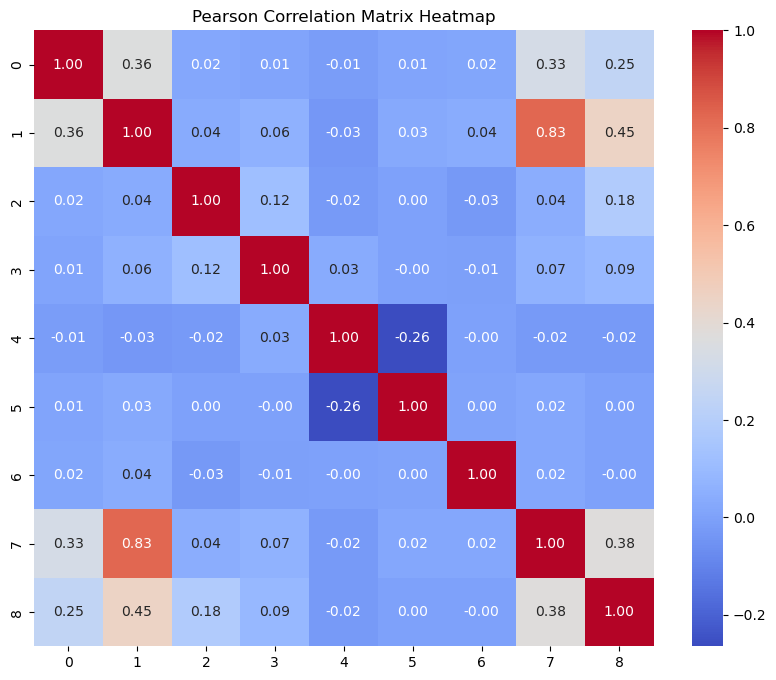

In [17]:
correlation_matrix = np.array([[1.0, 0.3633808366339157, 0.021656420949119116, 0.011657536945827279, -0.013175247731345105, 0.008140506860914769, 0.015544869990236977, 0.3273108644790775, 0.2479760088263859],
                               [0.3633808366339157, 1.0, 0.03644205712694438, 0.060479186634014144, -0.033236549068070095, 0.029522668733787952, 0.038265046976325816, 0.8253751871582498, 0.4507599405644525],
                               [0.021656420949119116, 0.03644205712694438, 1.0, 0.11891482183398801, -0.022586112002348377, 0.000943463459297656, -0.02818205629910815, 0.0435438126926409, 0.1840299864598156],
                               [0.011657536945827279, 0.060479186634014144, 0.11891482183398801, 1.0, 0.03450114699010871, -0.0015688607314832395, -0.005828463527395217, 0.06614938943667806, 0.08655373089215278],
                               [-0.013175247731345105, -0.033236549068070095, -0.022586112002348377, 0.03450114699010871, 1.0, -0.2645782226294404, -0.0018396992337890224, -0.02350237864549247, -0.02317748608055788],
                               [0.008140506860914769, 0.029522668733787952, 0.000943463459297656, -0.0015688607314832395, -0.2645782226294404, 1.0, 0.0026110668041060686, 0.019139580187719926, 0.002157154257661041],
                               [0.015544869990236977, 0.038265046976325816, -0.02818205629910815, -0.005828463527395217, -0.0018396992337890224, 0.0026110668041060686, 1.0, 0.018754497394032822, -0.0008381273084343247],
                               [0.3273108644790775, 0.8253751871582498, 0.0435438126926409, 0.06614938943667806, -0.02350237864549247, 0.019139580187719926, 0.018754497394032822, 1.0, 0.3755904537649632],
                               [0.2479760088263859, 0.4507599405644525, 0.1840299864598156, 0.08655373089215278, -0.02317748608055788, 0.002157154257661041, -0.0008381273084343247, 0.3755904537649632, 1.0]])

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Pearson Correlation Matrix Heatmap')
plt.show()

In [18]:
# ['living_space', 'bathroom_number', 'floor_level', 'built_year', 'latitude', 'longitude', 'premium', 'bedroom_number', 'price']

In [19]:
t_df = t_df.drop('premium', 'longitude', 'property_id')

### Step 3: Data Wrangling and Transformation

In [20]:
# consider categorical and numerical variable treatment and transformations

In [21]:
t_df.printSchema()

root
 |-- living_space: double (nullable = true)
 |-- bathroom_number: integer (nullable = true)
 |-- property_type: string (nullable = true)
 |-- city: string (nullable = true)
 |-- floor_level: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- built_year: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- bedroom_number: integer (nullable = true)
 |-- address: string (nullable = true)
 |-- listing_label: string (nullable = true)
 |-- tenure: string (nullable = true)
 |-- price: integer (nullable = true)



#### Numerical Transformation

In [22]:
log_list = ['living_space']
#boxcox = []
power_transformer = ['bathroom_number', 'bedroom_number', 'floor_level']

# handling latitude with a different scaler (minmax or robust later on)

In [23]:
from pyspark.sql.functions import col, log1p
# Log transformation
t_df = t_df.withColumn("log_living_space", log1p(t_df.living_space))

# Power transformations
t_df = t_df.withColumn("sqrt_bathrooms", pow(t_df.bathroom_number, 0.5))
t_df = t_df.withColumn("sqrt_bedroom_number", pow(t_df.bedroom_number, 0.5))
t_df = t_df.withColumn("cbrt_floor_level", pow(t_df.floor_level, 1/3))

# Feature engineering: bathroom to bedroom ratio
t_df = t_df.withColumn('bathroom_bedroom_ratio',
                       when(col('bedroom_number') != 0,
                            col('bathroom_number') / col('bedroom_number')).otherwise(float('1')))

# Dropping old features
t_df = t_df.drop('living_space', 'bathroom_number', 'bedroom_number', 'floor_level')

In [24]:
from pyspark.sql import functions as F
# Create a list of columns with their respective null counts
null_counts = [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in t_df.columns]
# Compute the null counts for each column
t_df.agg(*null_counts).show()

+-------------+----+-----+----------+--------+-------+-------------+------+-----+----------------+--------------+-------------------+----------------+----------------------+
|property_type|city|state|built_year|latitude|address|listing_label|tenure|price|log_living_space|sqrt_bathrooms|sqrt_bedroom_number|cbrt_floor_level|bathroom_bedroom_ratio|
+-------------+----+-----+----------+--------+-------+-------------+------+-----+----------------+--------------+-------------------+----------------+----------------------+
|            0|   0|    0|         0|       0|      0|            0|     0|    0|               0|             0|                  0|               0|                     0|
+-------------+----+-----+----------+--------+-------+-------------+------+-----+----------------+--------------+-------------------+----------------+----------------------+



#### Categorical Data

In [25]:
# # Calculate the mean of 'price' for each 'property_type'
# mean_encoded = t_df.groupBy('property_type').agg(F.mean('price').alias('mean_price'))

# # Join the mean values to the original DataFrame based on 'property_type'
# t_df = t_df.join(mean_encoded, 'property_type')

# # Drop the original 'property_type' column
# t_df = t_df.drop('property_type')

# # Rename the newly added mean column appropriately
# t_df = t_df.withColumnRenamed('mean_price', 'property_type_mean_encoded')

# # Show the resulting DataFrame
# #t_df.show(5)

In [26]:

indexer = StringIndexer(inputCol="property_type", outputCol="property_type_indexed")
encoder = OneHotEncoder(inputCol="property_type_indexed", outputCol="property_type_onehot")

# Create a pipeline to execute both stages
pipeline = Pipeline(stages=[indexer, encoder])

# Fit and transform the data
t_df = pipeline.fit(t_df).transform(t_df)

t_df = t_df.drop('property_type_indexed')
t_df = t_df.drop('property_type')

# Show the resulting DataFrame
t_df.show(5)

+--------+-------+----------+-----------+--------------------+-------------+--------+-------+------------------+------------------+-------------------+------------------+----------------------+--------------------+
|    city|  state|built_year|   latitude|             address|listing_label|  tenure|  price|  log_living_space|    sqrt_bathrooms|sqrt_bedroom_number|  cbrt_floor_level|bathroom_bedroom_ratio|property_type_onehot|
+--------+-------+----------+-----------+--------------------+-------------+--------+-------+------------------+------------------+-------------------+------------------+----------------------+--------------------+
|   Dusit|Bangkok|      2010|13.79101869|Samsen Road, Dusi...|       NORMAL|Freehold|5500000|  4.35491234218231|1.4142135623730951| 1.4142135623730951|1.8171205928321397|                   1.0|       (2,[0],[1.0])|
|Bang Rak|Bangkok|      2013|  13.719531|88 Soi Surasak Su...|    CORPORATE|Freehold|5100000|3.5553480614894135|               1.0|         

In [27]:
# # Set the threshold for the minimum frequency of a category
# threshold = 2  # You can adjust this threshold based on your data

# # Get the frequency count of each category in the 'city' column
# city_counts = t_df.groupBy('city').count()

# # Get the list of rare cities based on the threshold
# rare_cities = city_counts.filter(F.col('count') < threshold).select('city').rdd.flatMap(lambda x: x).collect()

# # Replace rare cities with a common category (e.g., 'Other')
# t_df = t_df.withColumn('city_rare_encoded', F.when(F.col('city').isin(rare_cities), 'Other').otherwise(F.col('city')))

# # Get the mean price for each city
# city_means = t_df.groupBy('city_rare_encoded').agg(avg('price').alias('city_mean_price'))

# # Perform a join to mean encode 'city' column
# t_df = t_df.join(city_means, on='city_rare_encoded', how='left')

# # Drop the original 'city' column
# t_df = t_df.drop('city')

# # Drop the original 'city' column
# t_df = t_df.drop('city_rare_encoded')

# # Show the resulting DataFrame
# t_df.show(5)

In [28]:
threshold = 2  
city_counts = t_df.groupBy('city').count()

# Get the list of rare cities based on the threshold
rare_cities = city_counts.filter(F.col('count') < threshold).select('city').rdd.flatMap(lambda x: x).collect()

# Replace rare cities with a common category (e.g., 'Other_City')
t_df = t_df.withColumn('city_rare_encoded', F.when(F.col('city').isin(rare_cities), 'Other_City').otherwise(F.col('city')))

# Create a StringIndexer and OneHotEncoder for city_rare_encoded
indexer = StringIndexer(inputCol='city_rare_encoded', outputCol='city_indexed')
encoder = OneHotEncoder(inputCol='city_indexed', outputCol='city_onehot')

# Create a pipeline to execute both stages
pipeline = Pipeline(stages=[indexer, encoder])

# Fit and transform the data
t_df = pipeline.fit(t_df).transform(t_df)

# Drop intermediate columns and original 'city' column
t_df = t_df.drop('city_rare_encoded', 'city', 'city_indexed')

# Show the resulting DataFrame
t_df.show(5)

+-------+----------+-----------+--------------------+-------------+--------+-------+------------------+------------------+-------------------+------------------+----------------------+--------------------+---------------+
|  state|built_year|   latitude|             address|listing_label|  tenure|  price|  log_living_space|    sqrt_bathrooms|sqrt_bedroom_number|  cbrt_floor_level|bathroom_bedroom_ratio|property_type_onehot|    city_onehot|
+-------+----------+-----------+--------------------+-------------+--------+-------+------------------+------------------+-------------------+------------------+----------------------+--------------------+---------------+
|Bangkok|      2010|13.79101869|Samsen Road, Dusi...|       NORMAL|Freehold|5500000|  4.35491234218231|1.4142135623730951| 1.4142135623730951|1.8171205928321397|                   1.0|       (2,[0],[1.0])|(64,[56],[1.0])|
|Bangkok|      2013|  13.719531|88 Soi Surasak Su...|    CORPORATE|Freehold|5100000|3.5553480614894135|         

In [29]:
# Set the threshold for the minimum frequency of a category
threshold = 1 
state_counts = t_df.groupBy('state').count()

# Get the list of rare states based on the threshold
rare_states = state_counts.filter(F.col('count') < threshold).select('state').rdd.flatMap(lambda x: x).collect()

# Replace rare states with a common category (e.g., 'Other_State')
t_df = t_df.withColumn('state_rare_encoded', F.when(F.col('state').isin(rare_states), 'Other_State').otherwise(F.col('state')))

# Create a StringIndexer and OneHotEncoder for state_rare_encoded
indexer = StringIndexer(inputCol='state_rare_encoded', outputCol='state_indexed')
encoder = OneHotEncoder(inputCol='state_indexed', outputCol='state_onehot')

# Create a pipeline to execute both stages
pipeline = Pipeline(stages=[indexer, encoder])

# Fit and transform the data
t_df = pipeline.fit(t_df).transform(t_df)

# Drop intermediate columns and original 'state' column
t_df = t_df.drop('state_rare_encoded', 'state', 'state_indexed')

# Show the resulting DataFrame
t_df.show(5)

+----------+-----------+--------------------+-------------+--------+-------+------------------+------------------+-------------------+------------------+----------------------+--------------------+---------------+--------------+
|built_year|   latitude|             address|listing_label|  tenure|  price|  log_living_space|    sqrt_bathrooms|sqrt_bedroom_number|  cbrt_floor_level|bathroom_bedroom_ratio|property_type_onehot|    city_onehot|  state_onehot|
+----------+-----------+--------------------+-------------+--------+-------+------------------+------------------+-------------------+------------------+----------------------+--------------------+---------------+--------------+
|      2010|13.79101869|Samsen Road, Dusi...|       NORMAL|Freehold|5500000|  4.35491234218231|1.4142135623730951| 1.4142135623730951|1.8171205928321397|                   1.0|       (2,[0],[1.0])|(64,[56],[1.0])|(14,[0],[1.0])|
|      2013|  13.719531|88 Soi Surasak Su...|    CORPORATE|Freehold|5100000|3.555348

In [30]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
# StringIndexer to convert string labels into indices
indexer_label = StringIndexer(inputCol="listing_label", outputCol="listing_label_index")
indexer_tenure = StringIndexer(inputCol="tenure", outputCol="tenure_index")

# Fit and transform the StringIndexer
t_df = indexer_label.fit(t_df).transform(t_df)
t_df = indexer_tenure.fit(t_df).transform(t_df)

# OneHotEncoder to convert the indexed labels into binary vectors
encoder_label = OneHotEncoder(inputCol="listing_label_index", outputCol="listing_label_encoded")
encoder_tenure = OneHotEncoder(inputCol="tenure_index", outputCol="tenure_encoded")

# Fit and transform the OneHotEncoder
t_df = encoder_label.fit(t_df).transform(t_df)
t_df = encoder_tenure.fit(t_df).transform(t_df)

# Drop the original 'listing_label_index' column
t_df = t_df.drop('listing_label_index')

# Drop the original 'tenure_index' column
t_df = t_df.drop('tenure_index')

# Show the transformed DataFrame
t_df.show()

+----------+-----------+--------------------+-------------+--------+-------+------------------+------------------+-------------------+------------------+----------------------+--------------------+---------------+--------------+---------------------+--------------+
|built_year|   latitude|             address|listing_label|  tenure|  price|  log_living_space|    sqrt_bathrooms|sqrt_bedroom_number|  cbrt_floor_level|bathroom_bedroom_ratio|property_type_onehot|    city_onehot|  state_onehot|listing_label_encoded|tenure_encoded|
+----------+-----------+--------------------+-------------+--------+-------+------------------+------------------+-------------------+------------------+----------------------+--------------------+---------------+--------------+---------------------+--------------+
|      2010|13.79101869|Samsen Road, Dusi...|       NORMAL|Freehold|5500000|  4.35491234218231|1.4142135623730951| 1.4142135623730951|1.8171205928321397|                   1.0|       (2,[0],[1.0])|(64,[

In [31]:
# dropping of unnecessary features
t_df = t_df.drop('listing_label', 'tenure', 'address')

In [32]:
t_df.printSchema()
# Create a list of columns with their respective null counts
null_counts = [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in t_df.columns]
# Compute the null counts for each column
t_df.agg(*null_counts).show()


root
 |-- built_year: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- price: integer (nullable = true)
 |-- log_living_space: double (nullable = true)
 |-- sqrt_bathrooms: double (nullable = true)
 |-- sqrt_bedroom_number: double (nullable = true)
 |-- cbrt_floor_level: double (nullable = true)
 |-- bathroom_bedroom_ratio: double (nullable = true)
 |-- property_type_onehot: vector (nullable = true)
 |-- city_onehot: vector (nullable = true)
 |-- state_onehot: vector (nullable = true)
 |-- listing_label_encoded: vector (nullable = true)
 |-- tenure_encoded: vector (nullable = true)

+----------+--------+-----+----------------+--------------+-------------------+----------------+----------------------+--------------------+-----------+------------+---------------------+--------------+
|built_year|latitude|price|log_living_space|sqrt_bathrooms|sqrt_bedroom_number|cbrt_floor_level|bathroom_bedroom_ratio|property_type_onehot|city_onehot|state_onehot|listing_label_encode

In [33]:
from pyspark.ml.feature import MinMaxScaler, StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PolynomialExpansion

# Columns for MinMax scaling
min_max_cols = ['latitude']

# Columns for Standard scaling
standard_cols = ['property_type_onehot', 'built_year', 'log_living_space', 'sqrt_bathrooms', 'sqrt_bedroom_number', 'listing_label_encoded', 'tenure_encoded',
                 'cbrt_floor_level', 'bathroom_bedroom_ratio', 'city_onehot', 'state_onehot', 'property_type_onehot']

# Assemble MinMax columns
min_max_assembler = VectorAssembler(inputCols=min_max_cols, outputCol="min_max_features")
t_df = min_max_assembler.transform(t_df)

# Apply MinMax scaling
min_max_scaler = MinMaxScaler(inputCol="min_max_features", outputCol="min_max_scaled_features")
min_max_model = min_max_scaler.fit(t_df)
t_df = min_max_model.transform(t_df).drop("min_max_features")

# Perform polynomial expansion
poly_expansion_cols = ['sqrt_bedroom_number', 'sqrt_bathrooms', 'log_living_space']
poly_expansion_assembler = VectorAssembler(inputCols=poly_expansion_cols, outputCol="poly_expansion_features")
t_df = poly_expansion_assembler.transform(t_df)

poly_expansion = PolynomialExpansion(inputCol="poly_expansion_features", outputCol="poly_expanded_features", degree=2)
t_df = poly_expansion.transform(t_df).drop("poly_expansion_features")

# Scale the expanded features
poly_expanded_scaler = StandardScaler(inputCol="poly_expanded_features", outputCol="poly_expanded_scaled_features", 
                                      withStd=True, withMean=True)
poly_expanded_model = poly_expanded_scaler.fit(t_df)

t_df = poly_expanded_model.transform(t_df).drop("poly_expanded_features")

# Assemble Standard columns
standard_assembler = VectorAssembler(inputCols=standard_cols, outputCol="standard_features")
t_df = standard_assembler.transform(t_df)

# Apply Standard scaling
standard_scaler = StandardScaler(inputCol="standard_features", outputCol="standard_scaled_features", 
                                 withStd=True, withMean=True)
standard_model = standard_scaler.fit(t_df)
t_df = standard_model.transform(t_df).drop("standard_features")

# Show the resulting DataFrame
t_df.show(5)


+----------+-----------+-------+------------------+------------------+-------------------+------------------+----------------------+--------------------+---------------+--------------+---------------------+--------------+-----------------------+-----------------------------+------------------------+
|built_year|   latitude|  price|  log_living_space|    sqrt_bathrooms|sqrt_bedroom_number|  cbrt_floor_level|bathroom_bedroom_ratio|property_type_onehot|    city_onehot|  state_onehot|listing_label_encoded|tenure_encoded|min_max_scaled_features|poly_expanded_scaled_features|standard_scaled_features|
+----------+-----------+-------+------------------+------------------+-------------------+------------------+----------------------+--------------------+---------------+--------------+---------------------+--------------+-----------------------+-----------------------------+------------------------+
|      2010|13.79101869|5500000|  4.35491234218231|1.4142135623730951| 1.4142135623730951|1.81712

In [34]:
# Features to drop
features_to_drop = [
    'built_year', 'latitude', 'premium', 'city_onehot',
    'log_living_space', 'sqrt_bathrooms', 'sqrt_bedroom_number', 'state_onehot',
    'cbrt_floor_level', 'bathroom_bedroom_ratio', 'listing_label_encoded', 'tenure_encoded']

# Drop the specified features

t_df = t_df.drop(*features_to_drop)

### Step 4: Machine Learning Modelling

In [35]:
(train, test) = t_df.randomSplit([0.8, 0.2], seed=999)
t_df.drop()
#te.drop()

price,property_type_onehot,min_max_scaled_features,poly_expanded_scaled_features,standard_scaled_features
5500000,"(2,[0],[1.0])",[0.5751971771706698],[1.38229036841898...,[0.03484652125087...
5100000,"(2,[0],[1.0])",[0.5691604227829444],[0.17933108087394...,[0.03484652125087...
4630000,"(2,[0],[1.0])",[0.5702064389096475],[0.17933108087394...,[0.03484652125087...
5690000,"(2,[0],[1.0])",[0.5703178214293151],[-2.7248695460999...,[0.03484652125087...
6350000,"(2,[0],[1.0])",[0.5701781938564418],[-2.7248695460999...,[0.03484652125087...
6690000,"(2,[0],[1.0])",[0.5703178214293151],[0.17933108087394...,[0.03484652125087...
6490000,"(2,[0],[1.0])",[0.570480377418974],[0.17933108087394...,[0.03484652125087...
5300000,"(2,[0],[1.0])",[0.5691604227829444],[0.17933108087394...,[0.03484652125087...
4000000,"(2,[0],[1.0])",[0.5695131481693365],[-2.7248695460999...,[0.03484652125087...
5180000,"(2,[0],[1.0])",[0.5691604227829444],[0.17933108087394...,[0.03484652125087...


In [36]:
# Count the number of rows in the DataFrame
#num_rows = train.count()

# Count the number of columns in the DataFrame
#num_cols = len(train.columns)

#print("Number of rows:", num_rows)
#print("Number of columns:", num_cols)

In [37]:
# as well as a sample of 10 rows before heading into Machine Learning Modelling
#train.show(10)

In [38]:
#test.show(10)

In [39]:
# Get the feature columns (excluding the target 'price' column)
feature_columns = [col_name for col_name in train.columns if col_name != 'price']

# VectorAssembler for consolidating X columns in train data
feature_assembler = VectorAssembler(inputCols=feature_columns, outputCol="Xcols")
train = feature_assembler.transform(train).select("Xcols", "price")

# VectorAssembler for consolidating X columns in test data
test = feature_assembler.transform(test).select("Xcols", "price")

# Show consolidated X columns with the target in train and test data
train.show(5, truncate=False)
test.show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [40]:
train = train.select("Xcols", "price")
test = test.select("Xcols", "price")

### Step 5: Model Evaluation and Selection

In [41]:
from pyspark.ml.regression import LinearRegression

# Create a Linear Regression model
lr = LinearRegression(featuresCol='Xcols', labelCol='price')

# Fit the model on the training data
lr = lr.fit(train)


In [42]:
train_pred_results=lr.evaluate(train)
train_pred_results.predictions.show()

+--------------------+-----+------------------+
|               Xcols|price|        prediction|
+--------------------+-----+------------------+
|[1.0,0.0,0.568136...|    0| 4354678.646620142|
|[1.0,0.0,0.569046...|    0|1596138.3393435841|
|[1.0,0.0,0.572853...|    0|2236686.3320007445|
|[1.0,0.0,0.573507...|    0|2952345.1834324067|
|[1.0,0.0,0.576426...|    0| 3540017.839740902|
|[1.0,0.0,0.581259...| 6500|1795987.3048493867|
|[1.0,0.0,0.566183...| 6900|2202965.8950166325|
|[1.0,0.0,0.569360...| 7500|1342781.8853594176|
|[1.0,0.0,0.577589...| 7500|2965147.9158131257|
|[1.0,0.0,0.566247...| 8000|2549299.8090984738|
|[1.0,0.0,0.566717...| 8000| 3030147.423035207|
|[1.0,0.0,0.572696...| 8000|2174045.2438758872|
|[1.0,0.0,0.574889...| 8500|2958331.0963126253|
|[1.0,0.0,0.568241...| 9500|2542475.7512203613|
|[1.0,0.0,0.569945...|10000|2039572.4351606371|
|[1.0,0.0,0.572312...|10000| 2884132.648543154|
|[1.0,0.0,0.568849...|10500|2844299.1584375626|
|[1.0,0.0,0.567737...|11000| 3284162.068

In [43]:
test_pred_results=lr.evaluate(test)

In [44]:
test_pred_results.predictions.show()

+--------------------+------+------------------+
|               Xcols| price|        prediction|
+--------------------+------+------------------+
|[1.0,0.0,0.568278...|     0| 3615925.821052347|
|[1.0,0.0,0.565969...|  7000|2084811.0684222083|
|[1.0,0.0,0.575450...|  7500|2050147.6269218076|
|[1.0,0.0,0.565779...|  8500| 2979655.910715208|
|[1.0,0.0,0.569812...|  8500|1710006.4940790986|
|[1.0,0.0,0.566377...| 10000| 3014722.498103971|
|[1.0,0.0,0.574594...| 11000|3559376.4107772987|
|[1.0,0.0,0.572130...| 13000|3448052.9646556037|
|[1.0,0.0,0.569160...| 15000|  5520743.77784141|
|[1.0,0.0,0.572908...| 15500| 3295355.305782629|
|[1.0,0.0,0.577409...| 16000|3891240.8835074175|
|[1.0,0.0,0.576479...| 19900| 3959835.952207638|
|[1.0,0.0,0.567726...| 23000|4048276.8073200355|
|[1.0,0.0,0.567088...| 30000|5359740.4893440455|
|[1.0,0.0,0.566523...| 45000| 4411677.311914374|
|[1.0,0.0,0.569456...| 50000| 7741633.253649784|
|[1.0,0.0,0.569821...| 60000| 5581422.697905658|
|[1.0,0.0,0.564171..

In [45]:
print("Train Metrics:")
print(f"Mean Absolute Error: {train_pred_results.meanAbsoluteError:.4f}")
print(f"Mean Squared Error : {train_pred_results.meanSquaredError:.4f}")
print(f"R-squared          : {train_pred_results.r2:.4f}")

Train Metrics:
Mean Absolute Error: 667333.4690
Mean Squared Error : 893878347409.3807
R-squared          : 0.6591


In [46]:
print("Test Metrics:")
print(f"Mean Absolute Error: {test_pred_results.meanAbsoluteError:.4f}")
print(f"Mean Squared Error : {test_pred_results.meanSquaredError:.4f}")
print(f"R-squared          : {test_pred_results.r2:.4f}")

Test Metrics:
Mean Absolute Error: 645000.2594
Mean Squared Error : 854352741021.8855
R-squared          : 0.6542


### Step 6: Report

# Table of Contents

1. [Problem Statement Formulation](#1.-Problem-Statement-Formulation)
2. [Exploratory Data Analysis and Data Cleansing](#2.-Exploratory-Data-Analysis-and-Data-Cleansing)
3. [Data Wrangling and Transformation](#3.-Data-Wrangling-and-Transformation)
4. [Machine Learning Modelling](#4.-Machine-Learning-Modelling)
5. [Model Evaluation and Selection](#5.-Model-Evaluation-and-Selection)
6. [Summary and Further Improvements](#6.-Summary-and-Further-Improvements)

## 1. Problem Statement Formulation

I first started the spark session with the app name "Thailand Property Data Exploration" and then loaded the data (thailand_ppty_asg1.csv) into thailand_df. Once this was done I printed the schema to get the following:

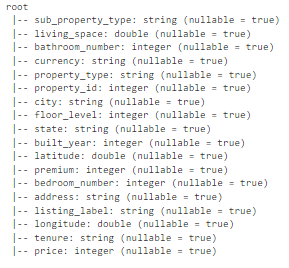

This is so as to see the structure of the data, including column names and their data types. 

Next I also displayed the top 5 rows so as that get a quick data preview and get a sense of what the dataset contains as well as to check that the data has been loaded in correctly.

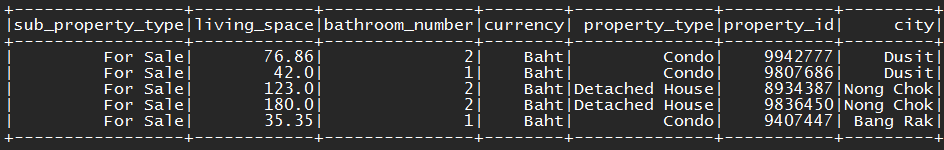

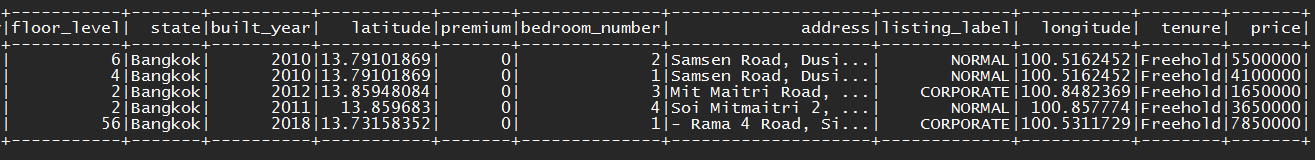

After considering the context stated I have formed the following **problem statement**:

To build a simple machine learning model to predict the price of any given Thailand Property transaction.

Developing an accurate predictive model for Thailand's property prices holds significant value for both real estate companies and potential buyers. For real estate firms, a reliable pricing model can enhance decision-making processes, aiding in property valuation, market analysis, and investment strategies. Simultaneously, potential buyers benefit from access to more transparent and fair property valuations, facilitating informed purchasing decisions and ensuring fair market value. 

There are a total of 41361 rows of data and 18 columns of data. Due to hardware restrictions I am unable to load the full 41361 rows of data and therefore I decided to simple random sample the dataset, getting instead 8272 rows of data.

The below report documents my initial handling of the dataset and, in the model evaluation, I make some improvements in the data in order to boost model performance. The code that was used to improve the dataset is used above to run the code.

## 2. Explorative Data Analysis and Data Cleansing

##### Null Handling

I counted the nulls in each feature and discovered that there were 50 nulls in 'living_space'. Due to the big size of the dataset of 41k I decided that dropping the 50 rows containing nulls would be optimal in order to prevent data bias.


##### Dropping of features

Next I started dropping the features. I first dropped the feature, 'currency' as the whole feature only contained one category which was 'Baht' and would just result in a meaningless feature.


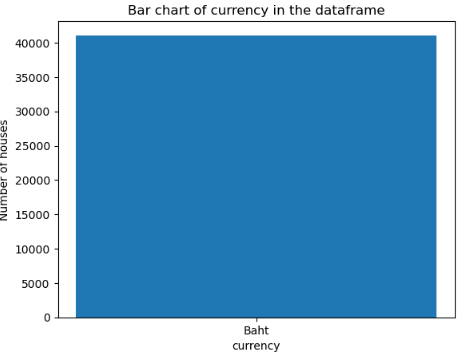

I then dropped the feature, 'sub_property_type' as it contained a high imbalance of categories, 'For Sale' and 'Option To Buy' which prompted me to investigate the difference between the two. In the context of properties they have the same implication and the two categories are synonymous, which means that this feature is the similar case to 'currency' where the whole feature does not show any difference between the data categories.

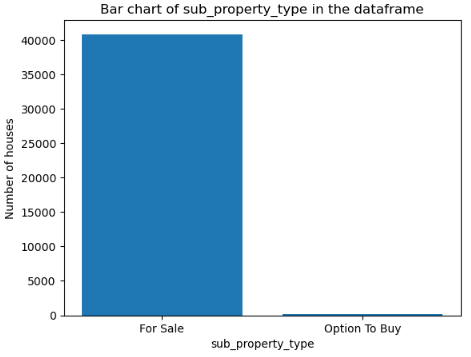

Notice that earlier on there were a lot of categories that had clear imbalances but I did not remove them. This was because in the problem statement, I am to predict the price of **any** given transaction. Which means that I cannot tailor the model to a specific category even though there are clear imbalances. The different meaning behind different categories might prove to be essential in contributing to model performance as well. However, there might be some changes later on after the first modelling iteration.

##### Outlier Handling

Next is to handle the clear outliers of the dataset. Due to the sheer size of the dataset I decided to just dropped the outliers again so as to prevent biased data.

I first filtered the data in 'year' to every year after 2006 as I believe that the data from years before 2006 were not relevant to the model's predictions if we were to predict current year's prices. 



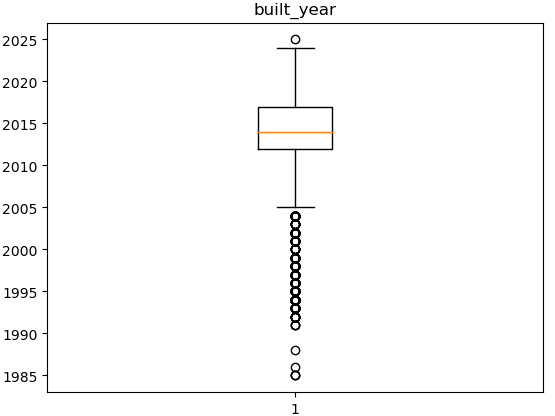

The second filter that I applied was on 'floor_level' and set it to below 85. With some research I found that the tallest building in Thailand had 85 levels, therefore the threshold was set at 85. However, with some experimentation later on, this value was further decreased to 70 in favour of model performance.

The third and last filter that I applied was on 'living_space' and set it at 1,500. With some research one of the biggest houses in Thailand, the Adrisa Villa has a floor space of 1,400 square meters. However, looking at the amount of outliers I reduced this number to 80 for the sake of model performance.

##### Other

In 'property_type' there is a negligible amount of the category 'Apartment'. Due to this I decided to replace all 'Apartments' to 'Condo' so as to remove noise from the data.

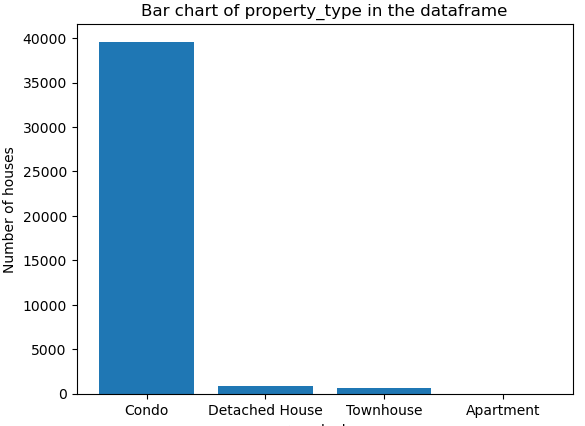

Plotting the Pearson Correlation matrix also told me that 'longitude' and 'premium' had close to no significance to predicting 'price'. This is evident from their values being 0.00 in the 'price' column/row. Therefore, in order to save memory and so as to remove noise, these two features were dropped as well.

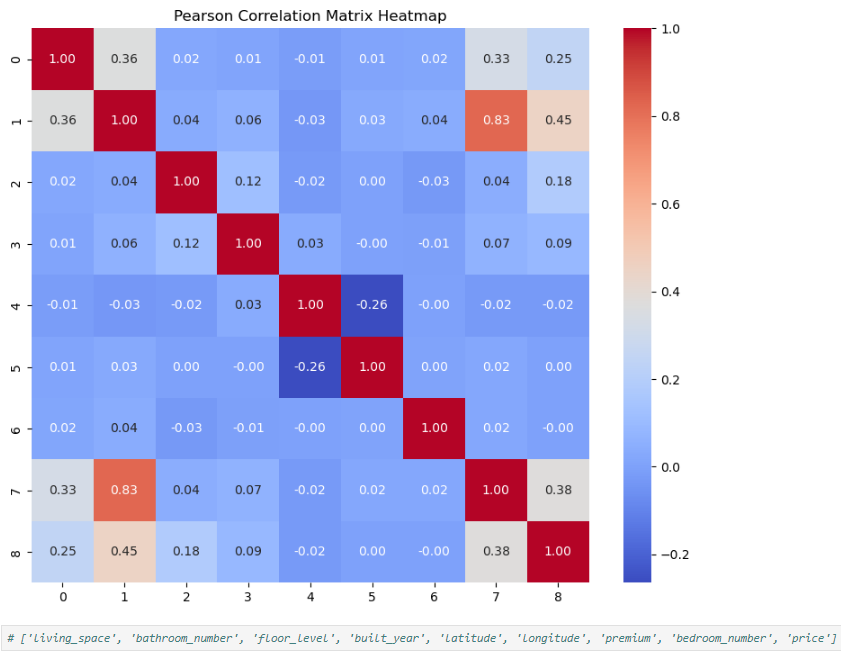

## 3. Data Wrangling and Transformation

At this stage, I had hardware problems which led me to reduce to number of rows to around 8272 at the start. However, I will increase this number of rows in the model evaluation section which makes this reasoning for my steps beforehand still valid.

##### Numerical Transformation

Upon observing the distributions of the features in the data exploration section, I decided to experiment with the different transformers being aware of their strengths and weaknesses in normalizing values. After experimentation, I implemented the LogTransformer and Power Transformer in the end.

Log transformers are effective at reducing right-skewed data and making the symmetric and on top of that, stabilizes the variance. However, it is unable to handle zero and negative values and can also lead to loss of information in highly skewed data. It also compresses extreme values, affecting model performance in certain cases. However, this transformation was still the most effective in handling the numerical feature, 'living_space'

Power transformers on the other hand has a flexibility to alter the power of which the data it is transforming and is effective in reducing skewness, particularly in right-skewed data and has less impact on extreme values. However, it might not be as interpretable as log transformation and it does not handle negative values well.

'living_space' is highly right-skewed and non-zero, therefore I used log transformer.

'bathroom_number' and 'bedroom_number' contains zero values and are right-skewed therefore I used square root transformer to handle the skewness and preserve the 0 values

'floor_level' is highly right-skewed and non-zero which is similar to the bathroom and bedroom numbers but a cube root transformation is more effective in handling skewness while preserving the non-zero nature of this feature.

Latitude and Longitude is Distributed with outliers but not skewed in any particular direction. Therefore, given the distribution and presence of outliers, scaling techniques like Min-Max scaling or Robust scaling could help in normalizing these features without impacting their distribution. Due to this, I decided to use min-max scaler on these features during the scaling section.

Lastly, I feature engineered a feature called 'bathroom_bedroom_ratio' which is the ratio of 'bathroom_number' to 'bedroom_number'. This is done by dividing 'bathroom_number' by 'bedroom_number', which caused null values due to the divide by 0 error. To solve this if the 'bedroom_number' is 0 it would be replaced with a 1 instead, to solve the null issue.

##### Categorical Encoding

In categorical encoding I encoded the features, 'property_type', 'city', 'state', 'tenure' and 'listing_label'.

For the three categories, 'property_type', 'city' and 'state' I used mean encoding to encode the three categories, with 'city' and 'state' having a rare encoder applied to them before hand. I decided to do this as there was a clear imbalance of categories between these categories and to help them capture the data more I decided to mean encode them instead.

For 'city', the threshold for rare categories is 2% and for 'state' the threshold is 1%. This gives me 19 and 14 categories respectively, inclusive of the rare categories.

Lastly, to encode 'listing_label' and 'tenure' I decided to use one-hot encoding. This is due to the low amount of categories for both categories. It also does not have as much of an imbalance in features. Therefore one-hot encoding was used. In this, I used MLlib pipeline in order to run string indexer on both 'listing_label' and 'tenure'. Then using one hot encoder to one hot encode both features and lastly using vector assembler to assemble the encoded features into a single vector column.

##### Scaling of Data

The last step of data wrangling is to scale the data. The code uses a list, numerical_cols_standard, to store all the features names that will be scaled using the standard scaler and another list, numerical_cols_minmax, to store the feature names that will be scaled using the MinMax scaler.

The features that will be using minmax scaler are 'latitude' and every other feature (other than the target 'price') will be scaled using standard scaler. 

Standard scaler is frequently used and it is especially good in our use case as it helps to center the features around zero with unit variance which makes it robust to outliers. However, one drawback is that it might not bound values to a specific range. 

On the other hand, MinMax scaler is used when there is a clear minimum and maximum in the data whilst maintining the original distribution but it is sensitive to outliers due to it scaling based on the minimum and maximum values in the data.

'latitude' uses MinMax scaler because most of values are within a small range and I decided that it would be beneficial to encode using MinMax scaler so as to scale the values in a specific range.

## 4. Machine Learning Modelling

Next I split the data with 80% of rows going to train and another 20% going to test.

After scaling I instantiated the model and below shows the initial model performance.

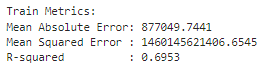
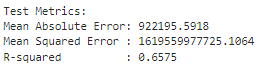

From the above it shows that the model is overfitting. Where the model is memorising the training data and is not generalizing well to the unseen test data. 

There could be some reasons to this. One could be due to the lack of data; due to my hardware not having enough memory, extracting all 41k+ data was proving to be a challenge. Another could be due to the usage of mean encoding on certain features as mean encoding does have a tendency to cause models to overfit. However, the lacking of data can be and is very impactful on model overfitting.

In order to reduce overfitting, I decided to use one hot encoding on 'property_type' instead. However if it continues to overfit I will then one hot encode 'state' and/or 'city' as well. If it continues to overfit I will alter the amount of data going into the pipeline, increasing it until my hardware is unable to take it.

The reason why I chose 'property_type', 'city' and/or 'state' in this case was due to the fact that they were encoded using mean encoding which helps to capture its relationship with the target. However, this might also lead to overfitting which is what our model is displaying right now where it performs better on the train dataset than the test dataset.

## 5. Model Evaluation and Selection

In this section we will be attempting to improve the model and then selecting the model which has the highest model performance, most suited for our use case.

After one hot encoding on 'property' type, the test performance increased slightly which decreases the overfitting. However the model is still overfitting which prompts me to one hot encode 'state' as well.

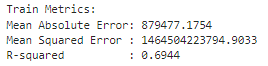
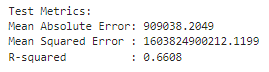

This change to one hot encoding of 'state' has increased the test performance relatively significantly with all the 3 metrics of test being close to the train metrics. Even though this is very clost to the desired result I will be experimenting with one hot encoding 'city' and potentially increasing the random sampling on the data.

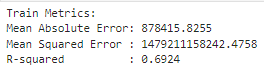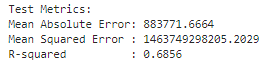

It turns out that one hot encoding city did make an improvement to the model's overall performance, with both MAE and MSE for train and test metrics decreasing and the R-squared increasing. Moreover, the difference in performance between the two models got smaller, evident from comparing their metrics. With this I will experiment with the random sample of the data.

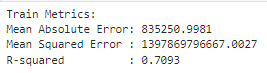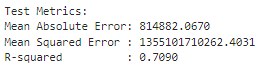

Experimenting with data sample, I was able to get 40% of the dataset which gives me 16727 rows of data. There seems to be an overall improvement in terms of model performance however the model performance is still less than desired due the the high MSE. This could be due to the outliers in the 'price'. Therefore, I decided to experiment with the quartiles which dictate which 'price' data are outliers. On top of that the model has started to underfit, this could be attributed to random difference.

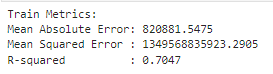
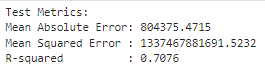

Altering the quartile range from before 0.25-0.75, to 0.3 to 0.65 has increased the model performance. As you can see from the image below, the MAE and MSE has decreased significantly but the r^2 value has decreased significantly as well. However, since our use case is to predict 'price', lowering of MAE and MSE are generally more important. From the results below, it also shows that the model is slightly underfitting as well.

To solve this underfitting, I decided to generate polynomial features so as to capture nonlinear relationships. This polynomial expansion would involve the features, 'bedroom_number', 'bathroom_number', and 'living_space' with a degree of 2.

These quartile values were derived after experimentation and has yielded the best model performance overall. Due to the range of values of 'price' between 0.3 and 0.65 and we used outlier trimming to handle this, checking the amount of rows to make sure there is enough data, there is 12367 rows of data which is still ok for machine learning modelling as well as any of previous steps for data preparation.

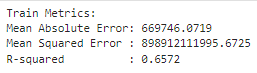
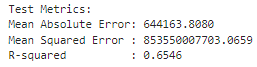

After polynomial expansion, the model's train metrics improved while the test metrics worsened but overall the model slightly improved. This model if by far the best model looking at MAE and MSE. Seeing as how the model has started to underfit this is the selected model for our use case as this model could perhaps be only improved by using a different and more complex model in order to achieve greater heights.

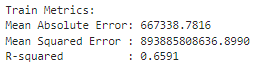
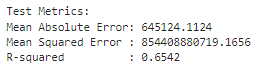

## 6. Summary and Further Improvements

This report details the steps to the initial data preparation, cleansing, and data wrangling, where I used pyspark to perform all the neccessary steps to creating a machine learning model to predict the prices of Thailand's property transactions. Throughout this dataset I 
had hardware restrictions which led me to perform the data exploration, preparation, and wrangling steps with a random sample of 8272 rows of data. With pyspark, I explored the box plots for numerical features as well as bar plots for categorical features so as to see their distribution and derive conclusions as to how I should handle them in the future. I also plotted the Pearson's Correlation Matrix so as to see the multicollinearity of the different features and how significant they are to contributing to model performance. Using the Matrix I dropped the feature 'longitude' and 'premium'.

After doing the transformation and encoding as well as scaling techniques, I then created a baseline model to guage the model performance. From then on I experimented with various ways of handling the data and made significant leaps to increasing the model performance with each iteration. However, the model's end result is still extremely unsatisfactory due to the high MAE and MSE scores and might not produce useful or accurate predictions, even in the last iteration of the model. However, they could still serve as a guideline on how users should price their properties.

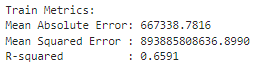
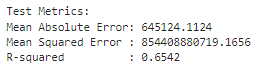

Some further improvements that could have been done to increase the model performance is to use different and more complex models such as deep learning models or decision trees. As well as due to hardware problems I was unable to load the entire dataset and was restricted to only using a portion of it, this could have reduced overfitting and allowed my model to better generalize to unseen data. Gathering external data as well could have been useful by feature engineering and implementing an API in order to find houses based on their addresses. Implementing K-fold cross-validation could have also aided in evaluating model stability and generalization on different subsets of data. 

However, one main issue was that the objective was to build a machine learning model to predict the price of ANY given Thailand Property transaction which meant that we were unable to filter the data to make the model more focused on a type of property or city or state as these factors could cause prices to differ a lot which would explain the large range of outliers in 'price'. These outliers are evident to be a problem to the model as upon customizing the quartiles at which outliers would be trimmed in 'price' it made the most significant positive impact on model performance but trimming these outliers loses a lot of data for some categories as well, but in favour of general accuracy and prediction this had to be done. 

It would benefit the organisation a lot more to create specialised machine learning models instead of a general one to prevent these outliers from having as much of an effect and therefore produce accurate prediction models.

Video Presentation link: on BONGO